In [19]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import random
        
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models


random.seed(42)
# ---------------------- 1. 数据加载与归一化 ----------------------
# CSV 文件包含的特征
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

data = pd.read_csv('diabetes_dataset_1.csv')

# 对所有特征进行 min–max 归一化
data_norm = data.copy()
for col in feature_cols:
    min_val = data[col].min()
    max_val = data[col].max()
    data_norm[col] = (data[col] - min_val) / (max_val - min_val)

# ---------------------- 2. 利用 ReliefF 自动计算特征重要性 ----------------------
# 需要安装 skrebate：pip install skrebate
from skrebate import ReliefF

X = data_norm[feature_cols].values
y = data_norm['Outcome'].values

# 初始化 ReliefF 算法（邻居数设为10）
relief = ReliefF(n_neighbors=10)
relief.fit(X, y)
importance_scores = relief.feature_importances_

# 按照重要性降序排列，得到特征名称排序
ordered_indices = np.argsort(importance_scores)[::-1]
ordered_features = [feature_cols[i] for i in ordered_indices]
print("ReliefF 计算的特征重要性排序：", ordered_features)

# ---------------------- 3. 根据排序自动生成区域映射 ----------------------
# 定义预先设计好的区域列表，按面积从大到小排列（格式：(x, y, width, height)）
predefined_regions = [
    (0, 0, 80, 80),    # 面积：80x80=6400，分配给最重要的特征
    (80, 0, 40, 60),   # 面积：40x60=2400
    (0, 80, 50, 40),   # 面积：50x40=2000
    (50, 80, 40, 30),  # 面积：40x30=1200
    (80, 60, 40, 20),  # 面积：40x20=800
    (90, 80, 30, 20),  # 面积：30x20=600
    (50, 110, 25, 10), # 面积：25x10=250
    (75, 110, 20, 10)  # 面积：20x10=200
]

self_region_mapping = {
    "Age": (0, 0, 69, 60),                     # Feature_7
    "SkinThickness": (69, 0, 51, 60),          # Feature_3
    "BMI": (0, 60, 59, 40),                    # Feature_5
    "Pregnancies": (59, 60, 32, 40),           # Feature_0
    "Insulin": (91, 60, 29, 40),               # Feature_4
    "DiabetesPedigreeFunction": (0, 100, 75, 20),  # Feature_6
    "BloodPressure": (75, 100, 39, 20),        # Feature_2
    "Glucose": (114, 100, 6, 20)               # Feature_1
}

# 自动将预定义区域分配给排序后的特征
auto_region_mapping = {}
for i, feat in enumerate(ordered_features):
    auto_region_mapping[feat] = predefined_regions[i]

print("自动生成的区域映射：")
for feat, region in auto_region_mapping.items():
    print(f"{feat}: {region}")





ReliefF 计算的特征重要性排序： ['Glucose', 'BMI', 'SkinThickness', 'Pregnancies', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure', 'Insulin']
自动生成的区域映射：
Glucose: (0, 0, 80, 80)
BMI: (80, 0, 40, 60)
SkinThickness: (0, 80, 50, 40)
Pregnancies: (50, 80, 40, 30)
Age: (80, 60, 40, 20)
DiabetesPedigreeFunction: (90, 80, 30, 20)
BloodPressure: (50, 110, 25, 10)
Insulin: (75, 110, 20, 10)


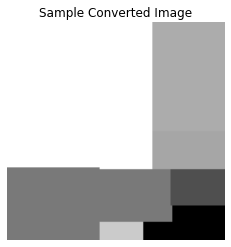

In [20]:
def create_image_from_features(sample, region_mapping):
    """
    根据单个样本的归一化特征和给定的 region_mapping 生成 120x120 灰度图像
    """
    img = Image.new('L', (120, 120), color=0)  # 创建黑底图
    draw = ImageDraw.Draw(img)
    
    # 对于每个特征，根据 mapping 中的区域将值映射到 0-255 灰度值
    for feat in feature_cols:
        val = int(sample[feat] * 255)
        if feat in region_mapping:
            x, y, w, h = region_mapping[feat]
            draw.rectangle([x, y, x + w, y + h], fill=val)
    return img

# 可视化查看一个样本转换后的图像
sample_img = create_image_from_features(data_norm.iloc[0], auto_region_mapping)
plt.imshow(sample_img, cmap='gray')
plt.title("Sample Converted Image")
plt.axis('off')
plt.show()

Epoch 1/20 - Loss: 0.5208 - Train Acc: 73.67% - Test Acc: 73.44%
Epoch 2/20 - Loss: 0.4778 - Train Acc: 75.81% - Test Acc: 73.44%
Epoch 3/20 - Loss: 0.4407 - Train Acc: 78.52% - Test Acc: 76.69%
Epoch 4/20 - Loss: 0.4104 - Train Acc: 80.66% - Test Acc: 77.47%
Epoch 5/20 - Loss: 0.3812 - Train Acc: 82.23% - Test Acc: 74.87%
Epoch 6/20 - Loss: 0.3656 - Train Acc: 82.71% - Test Acc: 76.17%
Epoch 7/20 - Loss: 0.3005 - Train Acc: 86.85% - Test Acc: 75.65%
Epoch 8/20 - Loss: 0.2773 - Train Acc: 88.87% - Test Acc: 75.91%
Epoch 9/20 - Loss: 0.2558 - Train Acc: 89.58% - Test Acc: 76.04%
Epoch 10/20 - Loss: 0.2129 - Train Acc: 91.21% - Test Acc: 76.56%
Epoch 11/20 - Loss: 0.1838 - Train Acc: 93.00% - Test Acc: 77.86%
Epoch 12/20 - Loss: 0.1459 - Train Acc: 94.66% - Test Acc: 77.47%
Epoch 13/20 - Loss: 0.1273 - Train Acc: 94.95% - Test Acc: 79.82%
Epoch 14/20 - Loss: 0.1404 - Train Acc: 94.73% - Test Acc: 79.30%
Epoch 15/20 - Loss: 0.1158 - Train Acc: 95.21% - Test Acc: 78.39%
Epoch 16/20 - Loss:

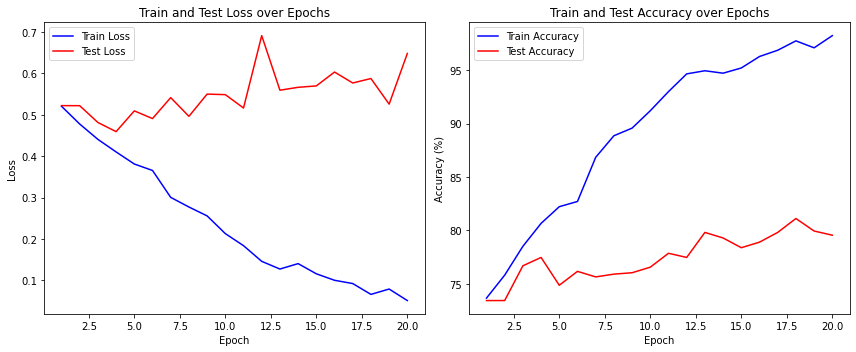

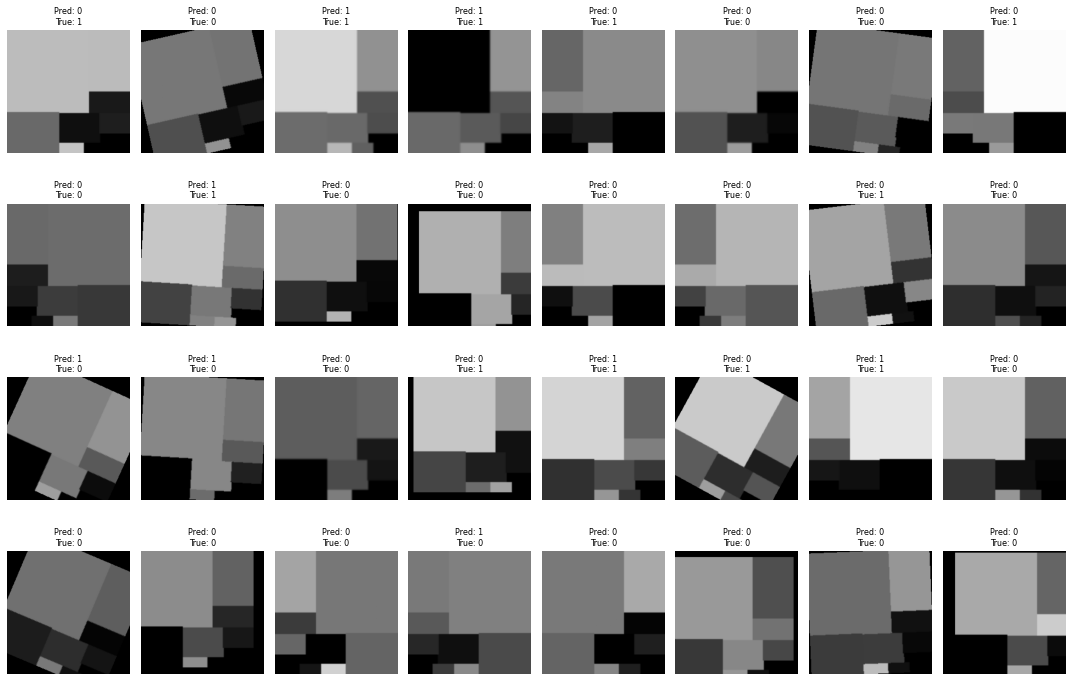

In [24]:


# ---------------------- 5. 定义 PyTorch 数据集 ----------------------
class PimaImageDataset(Dataset):
    def __init__(self, X, y):
        """
        df：包含归一化特征及 Outcome 的 DataFrame
        """
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx]
        label = int(self.y[idx])
        img = transforms.ToTensor()(img)
        return img, label

# ---------------------- 6. 数据增强与数据加载器 ----------------------
def convert_to_rgb(img):
    return img.convert('RGB')

# 一维转二维
def changeToTwoD(dataset, region_mapping):
    features = []
    labels = []
    for idx in range(dataset.shape[0]):
        img = convert_to_rgb(create_image_from_features(dataset.iloc[idx], region_mapping))

        resize = transforms.Resize(size=(224, 224))
        img = resize.forward(img)

        label = int(dataset.iloc[idx]['Outcome'])
        features.append(img)
        labels.append(label)
    return features, labels

# 这里对2D图像通过几何变换进行数据增广
def create_artificial_records(img_features, img_labels):
    artificial_features = []
    artificial_labels = []
    for i, imfe in enumerate(img_features):

        img = [0] * 4

        flip = transforms.RandomHorizontalFlip(p=1)
        rotate = transforms.RandomRotation(30)
        scale = transforms.Resize(size=(int(120 * random.uniform(0.9,1.1)), int(120 * random.uniform(0.9,1.1))))
        translate = transforms.RandomAffine(0, translate=(0.1, 0.1))

        resize = transforms.Resize(size=(224, 224))

        img[0] = flip.forward(imfe)
        img[1] = rotate.forward(imfe)
        img[2] = scale.forward(imfe)
        img[3] = translate.forward(imfe)
        img = [resize.forward(_im) for _im in img]
        artificial_features += img
        artificial_labels += [img_labels[i]] * 4
    return artificial_features, artificial_labels

img_features, img_labels = changeToTwoD(data_norm, auto_region_mapping)
aug_img_features, aug_img_labels = create_artificial_records(img_features, img_labels)
all_features = img_features + aug_img_features
all_labels = img_labels + aug_img_labels

# 下面还要改改
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    all_features, all_labels, test_size=0.2, random_state=42
)

train_dataset = PimaImageDataset(X_train, y_train)
test_dataset = PimaImageDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ---------------------- 7. 定义并微调预训练的 ResNet18 模型 ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 两分类任务
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# ---------------------- 8. 训练与评估 ----------------------
num_epochs = 20
# 用于记录每个 epoch 的指标
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()
    
    epoch_loss = running_loss / total_train
    train_acc = correct_train / total_train * 100

    # 测试集评估
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (preds == labels).sum().item()
    test_loss = running_test_loss / total_test
    test_acc = correct_test / total_test * 100
    
    train_loss_list.append(epoch_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Train Acc: {train_acc:.2f}% - Test Acc: {test_acc:.2f}%")
    
    
    
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
final_test_acc = correct / total * 100
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

# ---------------------- 10. 绘制指标曲线 ----------------------
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# 绘制 Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, 'b-', label='Train Loss')
plt.plot(epochs, test_loss_list, 'r-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()

# 绘制 Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, 'b-', label='Train Accuracy')
plt.plot(epochs, test_acc_list, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------- 11. 可视化部分 ----------------------
model.eval()
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

images_np = images.cpu().numpy().transpose((0, 2, 3, 1))

batch_size = images_np.shape[0]
cols = 8
rows = batch_size // cols if batch_size % cols == 0 else batch_size // cols + 1
plt.figure(figsize=(15, 2.5 * rows))
for i in range(batch_size):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images_np[i])
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()
